# DNS Ad-Blocker Training

Train XGBoost model to block ads at DNS level using domain name features.

In [80]:
!pip3 install tldextract

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from enhanced_dns_features import EnhancedDNSFeatureExtractor as DNSFeatureExtractor
from tqdm.auto import tqdm

np.random.seed(42)
print("Libraries loaded")

Libraries loaded


## Load Dataset

In [81]:
df = pd.read_csv('/content/dns_training_data_balanced.csv')

print(f"Total domains: {len(df):,}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSample:")
print(df.head(10))

Total domains: 198,377

Label distribution:
label
0    99296
1    99081
Name: count, dtype: int64

Sample:
                      domain  label
0         thestandard.com.hk      0
1  psx.ign.us.intellitxt.com      1
2  www.propreviewadvisor.top      1
3                 capwiz.com      0
4                  chishi.ir      0
5                  bgdnes.bg      0
6          instrument.com.cn      0
7      cdns.mydirtyhobby.com      1
8                vnetfly.com      0
9        www.plumvpower.shop      1


## Extract Features

In [82]:
extractor = DNSFeatureExtractor()

print("Extracting features from 198k domains...\n")

features_list = []
for domain in tqdm(df['domain'], desc="Extracting"):
    try:
        features = extractor.extract_features(domain)
        features_list.append(features)
    except:
        features_list.append({})

features_df = pd.DataFrame(features_list)

print(f"\nFeatures extracted: {features_df.shape[1]}")
print(f"\nSample:")
print(features_df.head())

Extracting features from 198k domains...



Extracting:   0%|          | 0/198377 [00:00<?, ?it/s]


Features extracted: 68

Sample:
   domain_length  domain_name_length  subdomain_length  subdomain_count  \
0             18                  11                 0                0   
1             25                  10                10                3   
2             25                  17                 3                1   
3             10                   6                 0                0   
4              9                   6                 0                0   

   path_depth  digit_count  digit_ratio  hyphen_count  hyphen_ratio  \
0           2            0          0.0             0           0.0   
1           4            0          0.0             0           0.0   
2           2            0          0.0             0           0.0   
3           1            0          0.0             0           0.0   
4           1            0          0.0             0           0.0   

   underscore_count  ...  tld_is_country_code  tld_is_new_gtld  \
0                 0  ..

In [86]:
X = features_df.fillna(0)
y = df['label']

print(f"Feature matrix: {X.shape}")
print(f"Labels: {y.shape}")

Feature matrix: (198377, 68)
Labels: (198377,)


## Train-Test Split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train):,} samples")
print(f"Test: {len(X_test):,} samples")

Training: 158,701 samples
Test: 39,676 samples


## Train XGBoost Model

In [110]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'max_depth': 8,
    'learning_rate': 0.05,
    'min_child_weight': 3,
    'eval_metric': 'logloss',
    'seed': 42,
    'tree_method': 'hist',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
}

evals = [(dtrain, 'train'), (dtest, 'test')]
evals_result = {}

print("Training...\n")

model = xgb.train(
    params,
    dtrain,
    num_boost_round=6000,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=20,
    verbose_eval=20
)

print("\nTraining complete")

Training...

[0]	train-logloss:0.66435	test-logloss:0.66451
[20]	train-logloss:0.40013	test-logloss:0.40210
[40]	train-logloss:0.33256	test-logloss:0.33604
[60]	train-logloss:0.31072	test-logloss:0.31539
[80]	train-logloss:0.30231	test-logloss:0.30819
[100]	train-logloss:0.29832	test-logloss:0.30521
[120]	train-logloss:0.29597	test-logloss:0.30367
[140]	train-logloss:0.29433	test-logloss:0.30271
[160]	train-logloss:0.29273	test-logloss:0.30207
[180]	train-logloss:0.29127	test-logloss:0.30167
[200]	train-logloss:0.28994	test-logloss:0.30121
[220]	train-logloss:0.28862	test-logloss:0.30090
[240]	train-logloss:0.28744	test-logloss:0.30068
[260]	train-logloss:0.28624	test-logloss:0.30052
[280]	train-logloss:0.28487	test-logloss:0.30035
[300]	train-logloss:0.28348	test-logloss:0.30013
[320]	train-logloss:0.28219	test-logloss:0.30002
[340]	train-logloss:0.28105	test-logloss:0.29991
[360]	train-logloss:0.28014	test-logloss:0.29993
[366]	train-logloss:0.27987	test-logloss:0.29991

Training com

## Training Loss Curve

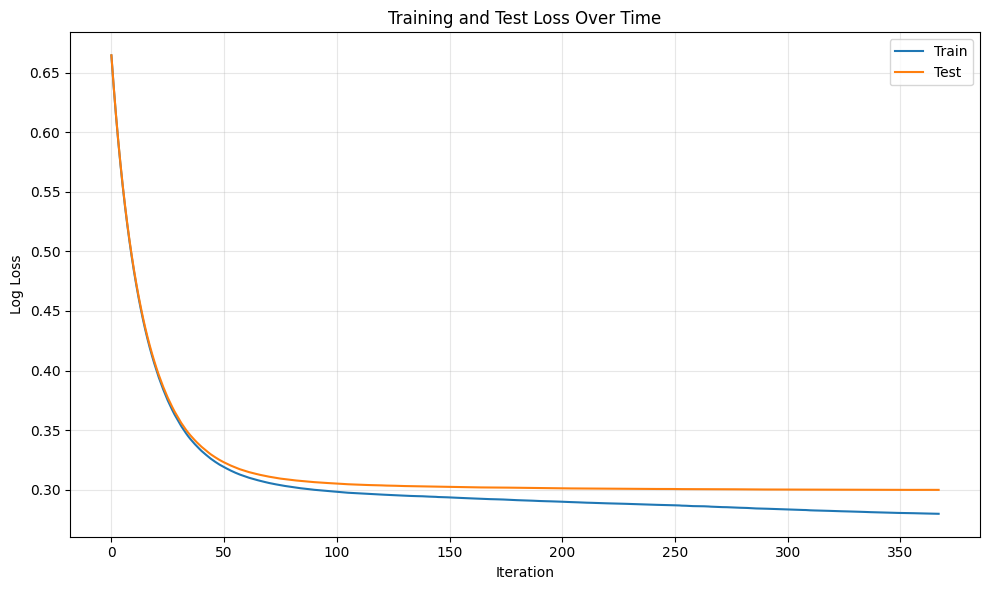

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['logloss'], label='Train')
plt.plot(evals_result['test']['logloss'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150)
plt.show()

## Evaluate Performance

In [112]:
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.75).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Ad']))

MODEL PERFORMANCE
Accuracy:  0.8510 (85.10%)
Precision: 0.9796 (97.96%)
Recall:    0.7166 (71.66%)
F1-Score:  0.8277 (82.77%)

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.78      0.99      0.87     19860
          Ad       0.98      0.72      0.83     19816

    accuracy                           0.85     39676
   macro avg       0.88      0.85      0.85     39676
weighted avg       0.88      0.85      0.85     39676



## Confusion Matrix

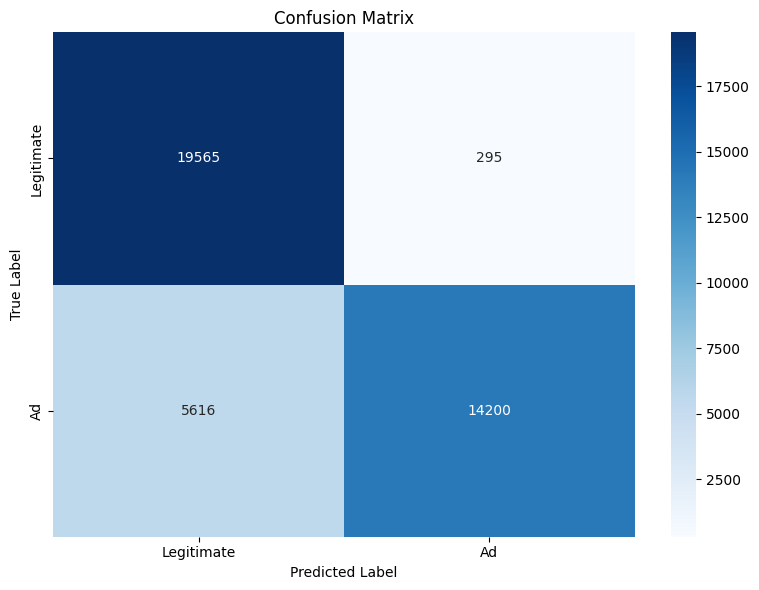

False Positive Rate: 0.0149 (1.49%)
False Negative Rate: 0.2834 (28.34%)


In [113]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Ad'],
            yticklabels=['Legitimate', 'Ad'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"False Negative Rate: {fnr:.4f} ({fnr*100:.2f}%)")

## Feature Importance

Top 15 Features:
                   feature  importance            feature_name
11                 entropy      2662.0                 entropy
12     domain_name_entropy      2518.0     domain_name_entropy
28       unique_char_ratio      2125.0       unique_char_ratio
9          consonant_ratio      1825.0         consonant_ratio
10             vowel_ratio      1777.0             vowel_ratio
46   vowel_consonant_ratio      1417.0   vowel_consonant_ratio
26  max_consonant_sequence      1291.0  max_consonant_sequence
41      alphanumeric_ratio      1269.0      alphanumeric_ratio
40       tld_to_full_ratio      1216.0       tld_to_full_ratio
39    domain_to_full_ratio      1192.0    domain_to_full_ratio
0            domain_length       831.0           domain_length
6              digit_ratio       803.0             digit_ratio
42     max_char_repetition       798.0     max_char_repetition
20              tld_length       709.0              tld_length
21       is_commercial_tld       601.0

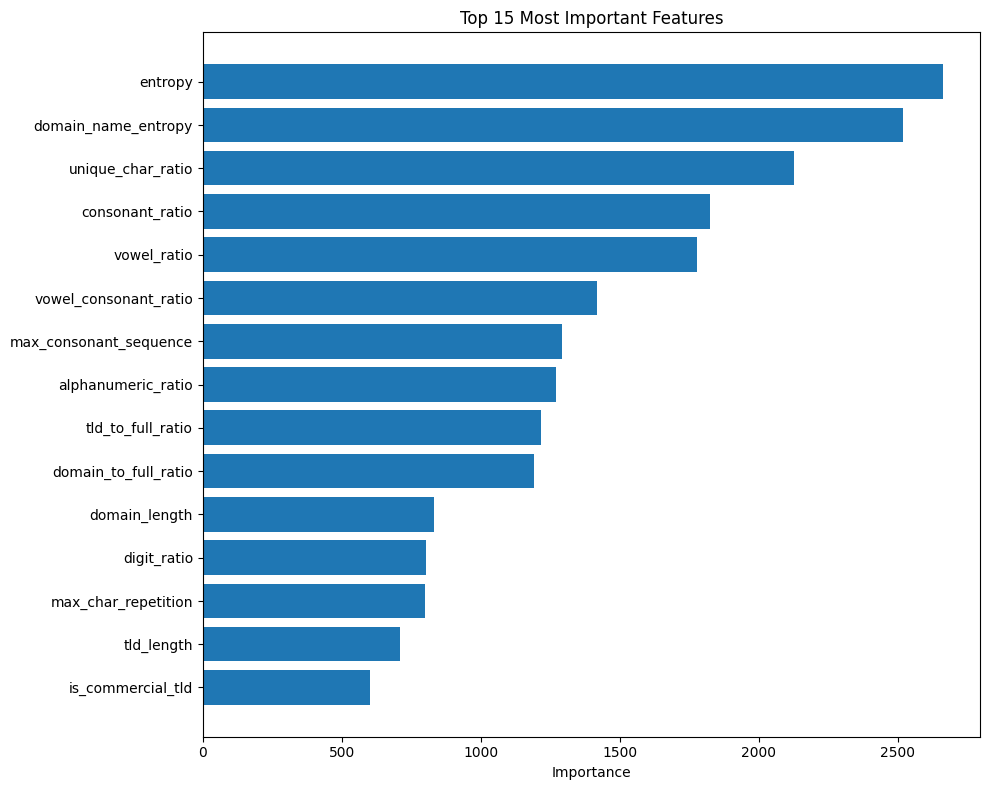

In [114]:
importance = model.get_score(importance_type='weight')

feature_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

feature_names = X.columns.tolist()
feature_importance['feature_name'] = feature_importance['feature'].apply(
    lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') else x
)

print("Top 15 Features:")
print(feature_importance.head(15))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature_name'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

Top 15 Features:
                       feature   importance                feature_name
2             subdomain_length  4805.404785            subdomain_length
3              subdomain_count  2117.012207             subdomain_count
7                 hyphen_count   148.921112                hyphen_count
0                domain_length   139.259125               domain_length
4                   path_depth    93.078873                  path_depth
48        avg_subdomain_length    73.488792        avg_subdomain_length
47            subdomain_levels    56.116474            subdomain_levels
58        part_length_variance    38.201366        part_length_variance
20                  tld_length    26.949062                  tld_length
1           domain_name_length    25.055487          domain_name_length
19              tld_suspicious    23.889002              tld_suspicious
53         tld_is_country_code    22.776821         tld_is_country_code
34           cdn_keyword_count    14.922587    

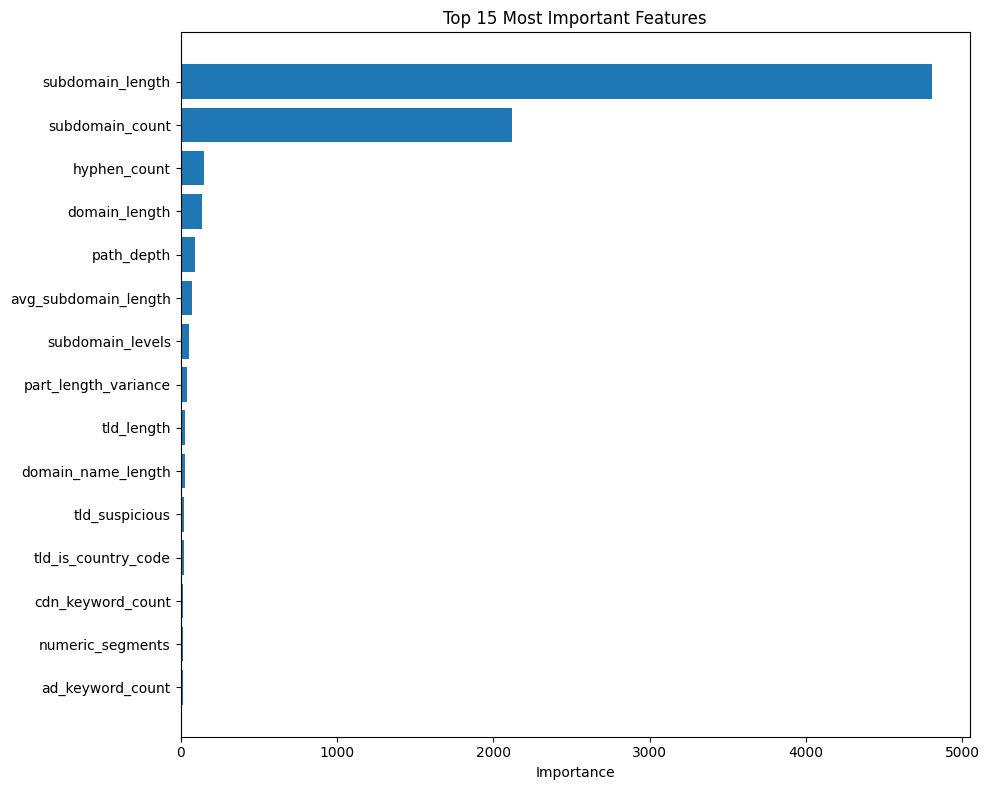

In [115]:
importance = model.get_score(importance_type='gain')

feature_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)

feature_names = X.columns.tolist()
feature_importance['feature_name'] = feature_importance['feature'].apply(
    lambda x: feature_names[int(x.replace('f', ''))] if x.startswith('f') else x
)

print("Top 15 Features:")
print(feature_importance.head(68))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature_name'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()


Last 20 Features (Least Important):
                      feature  importance               feature_name
23        has_number_sequence    5.771894        has_number_sequence
26     max_consonant_sequence    5.649016     max_consonant_sequence
56           randomness_score    5.565259           randomness_score
22       has_multiple_hyphens    5.456789       has_multiple_hyphens
24         starts_with_number    5.337122         starts_with_number
9             consonant_ratio    5.102214            consonant_ratio
37         matches_ad_network    4.993087         matches_ad_network
46      vowel_consonant_ratio    4.862839      vowel_consonant_ratio
16      keyword_with_boundary    4.718111      keyword_with_boundary
30       has_tracking_pattern    4.646792       has_tracking_pattern
52   domain_name_ends_with_ad    4.390860   domain_name_ends_with_ad
49       subdomain_has_number    4.259566       subdomain_has_number
38  subdomain_to_domain_ratio    4.108176  subdomain_to_domain_rat

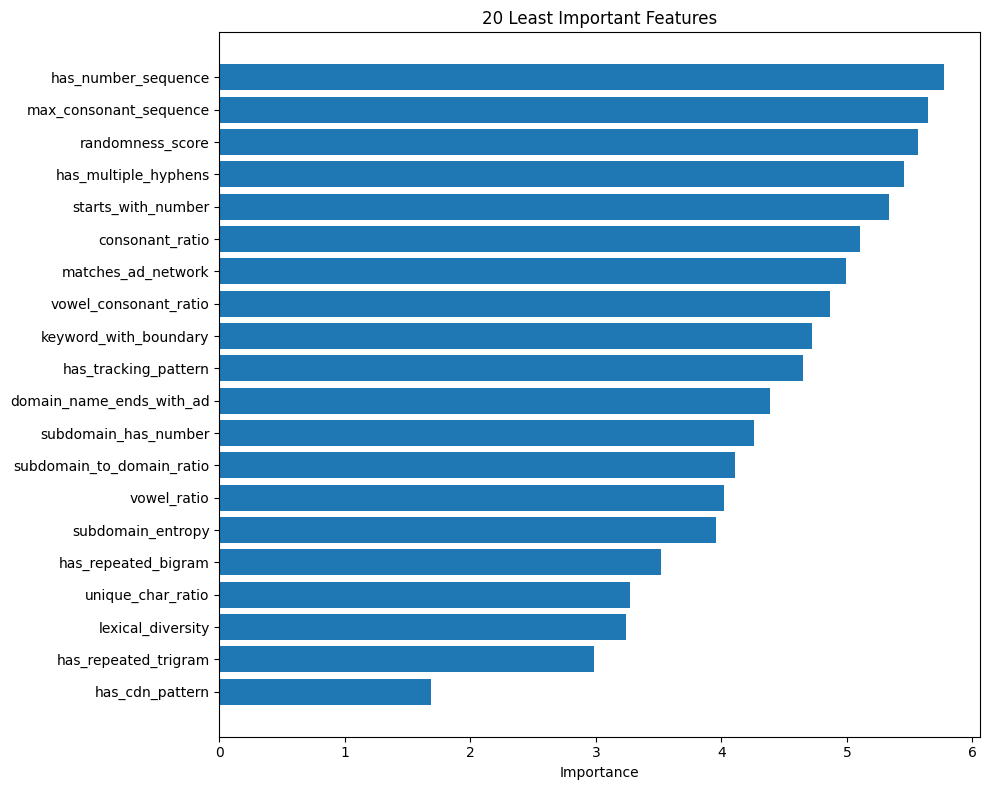

In [116]:
print("\nLast 20 Features (Least Important):")
last_20 = feature_importance.tail(20)
print(last_20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(last_20)), last_20['importance'])
plt.yticks(range(len(last_20)), last_20['feature_name'])
plt.xlabel('Importance')
plt.title('20 Least Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_last20.png', dpi=150)
plt.show()

## Save Model

In [ ]:
model.save_model('DNSadblocker_model.ubj')
model.save_model('DNSadblocker_model.json')

import json
with open('FeatureNames.json', 'w') as f:
    json.dump(X.columns.tolist(), f, indent=2)

import os
ubj_size = os.path.getsize('DNSadblocker_model.ubj') / 1024
json_size = os.path.getsize('DNSadblocker_model.json') / 1024

print("Model saved:")
print(f"  DNSadblocker_model.ubj ({ubj_size:.1f} KB)")
print(f"  DNSadblocker_model.json ({json_size:.1f} KB)")
print(f"  FeatureNames.json")
print(f"\nModel ready for deployment")

Model saved:
  DNSadblocker_model.ubj (20480.7 KB)
  DNSadblocker_model.json (35655.3 KB)
  FeatureNames.json

Model ready for deployment
